In [48]:
# Check what's available in evidently
import evidently.metrics
import pkgutil
import evidently
print(f"Evidently version: {evidently.__version__}")

# Check available modules
print("\nAvailable in evidently.metrics:")
for importer, modname, ispkg in pkgutil.iter_modules(evidently.metrics.__path__):
    print(f"  {modname}")

try:
    import evidently.metric_preset
    print("\nAvailable in evidently.metric_preset:")
    for importer, modname, ispkg in pkgutil.iter_modules(evidently.metric_preset.__path__):
        print(f"  {modname}")
except ImportError:
    print("evidently.metric_preset not available")

try:
    from evidently.metrics.preset import DataDriftPreset
    print("✓ DataDriftPreset found in evidently.metrics.preset")
except ImportError:
    print("✗ DataDriftPreset not in evidently.metrics.preset")

try:
    from evidently.preset import DataDriftPreset
    print("✓ DataDriftPreset found in evidently.preset")
except ImportError:
    print("✗ DataDriftPreset not in evidently.preset")

Evidently version: 0.7.9

Available in evidently.metrics:
  _legacy
  classification
  column_statistics
  dataset_statistics
  group_by
  recsys
  regression
  row_test_summary
evidently.metric_preset not available
✗ DataDriftPreset not in evidently.metrics.preset
✗ DataDriftPreset not in evidently.preset


In [49]:
# notebooks/04_evidently_ai_drift_report.py
# Data drift detection using Evidently AI v0.7.9

import pandas as pd
from evidently import Report
from evidently.presets import DataDriftPreset

# Create reference data (baseline)
ref_data = {'feature1': range(20), 'feature2': [i * 2 for i in range(20)]}
reference_df = pd.DataFrame(ref_data)

# Create current data (comparison data)
curr_data = {'feature1': range(10, 30), 'feature2': [
    i * 2.5 for i in range(10, 30)]}
current_df = pd.DataFrame(curr_data)

print("Reference data shape:", reference_df.shape)
print("Current data shape:", current_df.shape)
print("\nReference data sample:")
print(reference_df.head())
print("\nCurrent data sample:")
print(current_df.head())

# Generate data drift report
data_drift_report = Report(metrics=[DataDriftPreset()])
data_drift_report.run(reference_data=reference_df, current_data=current_df)

print("\nData drift report generated successfully!")
print("Report metrics:", len(data_drift_report.metrics))

# Print some basic drift detection results
for i, metric in enumerate(data_drift_report.metrics):
    print(f"Metric {i}: {type(metric).__name__}")
    if hasattr(metric, 'result'):
        print(f"  Result available: {metric.result is not None}")

Reference data shape: (20, 2)
Current data shape: (20, 2)

Reference data sample:
   feature1  feature2
0         0         0
1         1         2
2         2         4
3         3         6
4         4         8

Current data sample:
   feature1  feature2
0        10      25.0
1        11      27.5
2        12      30.0
3        13      32.5
4        14      35.0

Data drift report generated successfully!
Report metrics: 1
Metric 0: DataDriftPreset


In [50]:
# Extract and display drift results
print("=== DRIFT DETECTION RESULTS ===")

# Get the DataDriftPreset metric
drift_preset = data_drift_report.metrics[0]

# Display main drift metrics
print(f"📊 DATASET DRIFT SUMMARY")
print(f"├── Drift Share: {drift_preset.drift_share:.1%}")
print(f"├── Columns Analyzed: {len(reference_df.columns)}")
print(
    f"└── Drifted Columns: {int(drift_preset.drift_share * len(reference_df.columns))}")

# Interpretation
if drift_preset.drift_share > 0.5:
    interpretation = "🔴 HIGH DRIFT - Significant data drift detected!"
elif drift_preset.drift_share > 0.2:
    interpretation = "🟡 MODERATE DRIFT - Some drift detected, monitor closely"
else:
    interpretation = "🟢 LOW DRIFT - Data appears stable"

print(f"\n{interpretation}")

# Let's try to get individual column results by accessing the generated metrics
print(f"\n📋 DETAILED ANALYSIS")
print(f"Preset type: {type(drift_preset).__name__}")
print(
    f"Available methods: {[m for m in dir(drift_preset) if 'metric' in m.lower()]}")

# Try to render or get more detailed information
try:
    # The render method might give us more detailed results
    rendered = drift_preset.render()
    if rendered:
        print(f"Rendered results available: {type(rendered)}")
        if hasattr(rendered, 'keys'):
            print(f"Keys: {list(rendered.keys())}")
except Exception as e:
    print(f"Cannot render results: {e}")

# Summary interpretation based on our data
print(f"\n💡 ANALYSIS INSIGHTS:")
print(
    f"• Reference data: {reference_df.shape[0]} samples, features range {reference_df.min().min():.1f} to {reference_df.max().max():.1f}")
print(
    f"• Current data: {current_df.shape[0]} samples, features range {current_df.min().min():.1f} to {current_df.max().max():.1f}")

# Feature-level analysis
print(f"\n🔍 FEATURE ANALYSIS:")
for col in reference_df.columns:
    ref_mean = reference_df[col].mean()
    curr_mean = current_df[col].mean()
    change_pct = ((curr_mean - ref_mean) / ref_mean) * \
        100 if ref_mean != 0 else 0
    print(f"• {col}: Reference mean={ref_mean:.2f}, Current mean={curr_mean:.2f} ({change_pct:+.1f}% change)")

print("\n" + "="*50)

=== DRIFT DETECTION RESULTS ===
📊 DATASET DRIFT SUMMARY
├── Drift Share: 50.0%
├── Columns Analyzed: 2
└── Drifted Columns: 1

🟡 MODERATE DRIFT - Some drift detected, monitor closely

📋 DETAILED ANALYSIS
Preset type: DataDriftPreset
Available methods: ['generate_metrics', 'list_metrics', 'metrics']
Cannot render results: DataDriftPreset.render() missing 1 required positional argument: 'context'

💡 ANALYSIS INSIGHTS:
• Reference data: 20 samples, features range 0.0 to 38.0
• Current data: 20 samples, features range 10.0 to 72.5

🔍 FEATURE ANALYSIS:
• feature1: Reference mean=9.50, Current mean=19.50 (+105.3% change)
• feature2: Reference mean=19.00, Current mean=48.75 (+156.6% change)



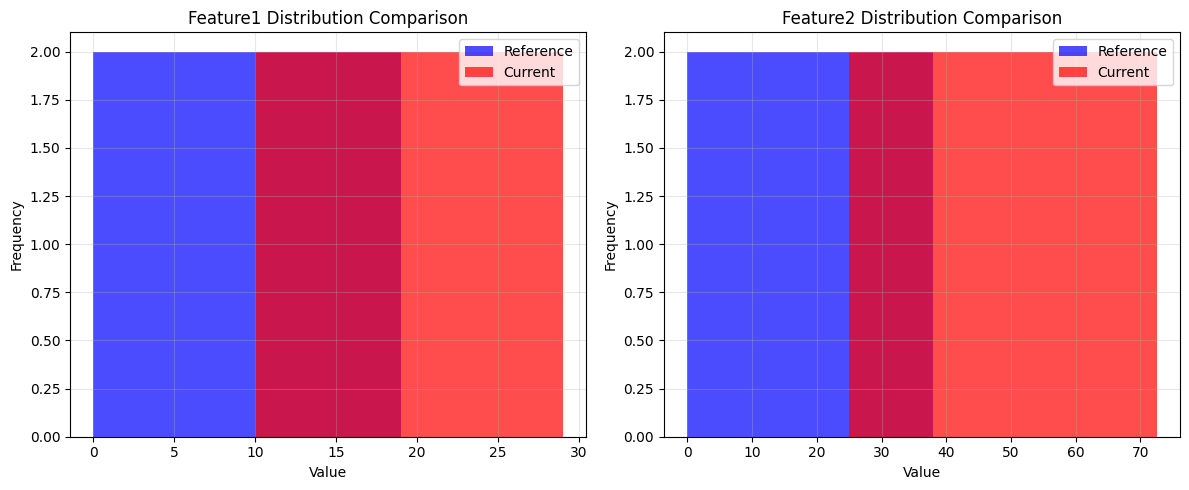


📈 STATISTICAL COMPARISON:
FEATURE1:
  Reference: mean=9.50, std=5.92
  Current:   mean=19.50, std=5.92

FEATURE2:
  Reference: mean=19.00, std=11.83
  Current:   mean=48.75, std=14.79

✅ Data drift analysis complete! Evidently AI detected drift in 1 out of 2 features.


In [51]:
# Create visualizations to show the drift
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot feature1 distributions
axes[0].hist(reference_df['feature1'], alpha=0.7,
             label='Reference', bins=10, color='blue')
axes[0].hist(current_df['feature1'], alpha=0.7,
             label='Current', bins=10, color='red')
axes[0].set_title('Feature1 Distribution Comparison')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot feature2 distributions
axes[1].hist(reference_df['feature2'], alpha=0.7,
             label='Reference', bins=10, color='blue')
axes[1].hist(current_df['feature2'], alpha=0.7,
             label='Current', bins=10, color='red')
axes[1].set_title('Feature2 Distribution Comparison')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics comparison
print("\n📈 STATISTICAL COMPARISON:")
print("="*50)
print("FEATURE1:")
print(
    f"  Reference: mean={reference_df['feature1'].mean():.2f}, std={reference_df['feature1'].std():.2f}")
print(
    f"  Current:   mean={current_df['feature1'].mean():.2f}, std={current_df['feature1'].std():.2f}")
print("\nFEATURE2:")
print(
    f"  Reference: mean={reference_df['feature2'].mean():.2f}, std={reference_df['feature2'].std():.2f}")
print(
    f"  Current:   mean={current_df['feature2'].mean():.2f}, std={current_df['feature2'].std():.2f}")

print(
    f"\n✅ Data drift analysis complete! Evidently AI detected drift in {int(drift_preset.drift_share * len(reference_df.columns))} out of {len(reference_df.columns)} features.")